In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import seaborn
import pandas as pd



In [6]:
f = 'narutos-theme-song.wav'


samplerate, data = wavfile.read(f)
print('Sampling Rate:',samplerate)
print('Audio Shape:',np.shape(data))

duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) #time vector
time = time[:len(time)]

print(f"длительность {duration} \n временная шкала {time} \n размерность времени {len(time)}")

canal1 = data[:,0]
canal2 = data[:,1]

Sampling Rate: 32000
Audio Shape: (627840, 2)
длительность 19.62 
 временная шкала [0.00000000e+00 3.12500000e-05 6.25000000e-05 ... 1.96199062e+01
 1.96199375e+01 1.96199688e+01] 
 размерность времени 627840


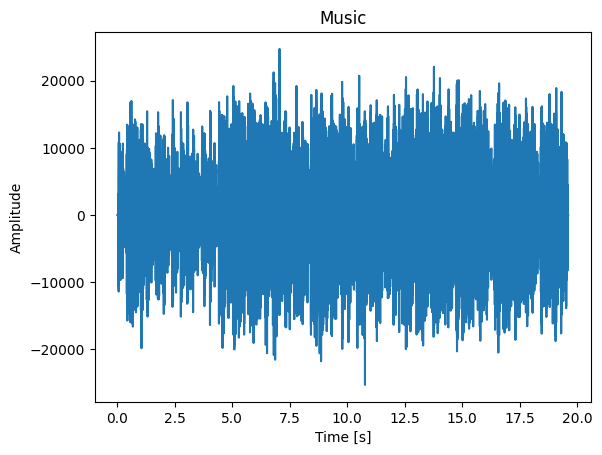

In [7]:


plt.plot(time, canal1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Music')
plt.show()



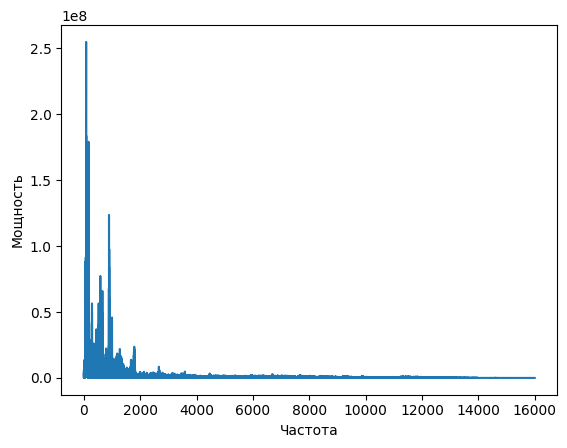

In [8]:
from scipy.fft import  rfft, rfftfreq, irfft


# число точек в normalized_tone
N = int(samplerate * duration)

yf = rfft(canal1)
xf = rfftfreq(N, 1 / samplerate)

plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

In [9]:
points_per_freq = len(xf) / (max(xf))

target_idx_hf = int(points_per_freq * 900)
target_idx_lf = int(points_per_freq * 300)

yf_hf = yf.copy()
yf_lf = yf.copy()
yf_bp = yf.copy()
yf_zf = yf.copy()

yf_hf[:target_idx_hf] = 0

yf_lf[target_idx_lf:] = 0

yf_bp[:target_idx_lf] = 0
yf_bp[target_idx_hf:] = 0

yf_zf[target_idx_lf:target_idx_hf] = 0

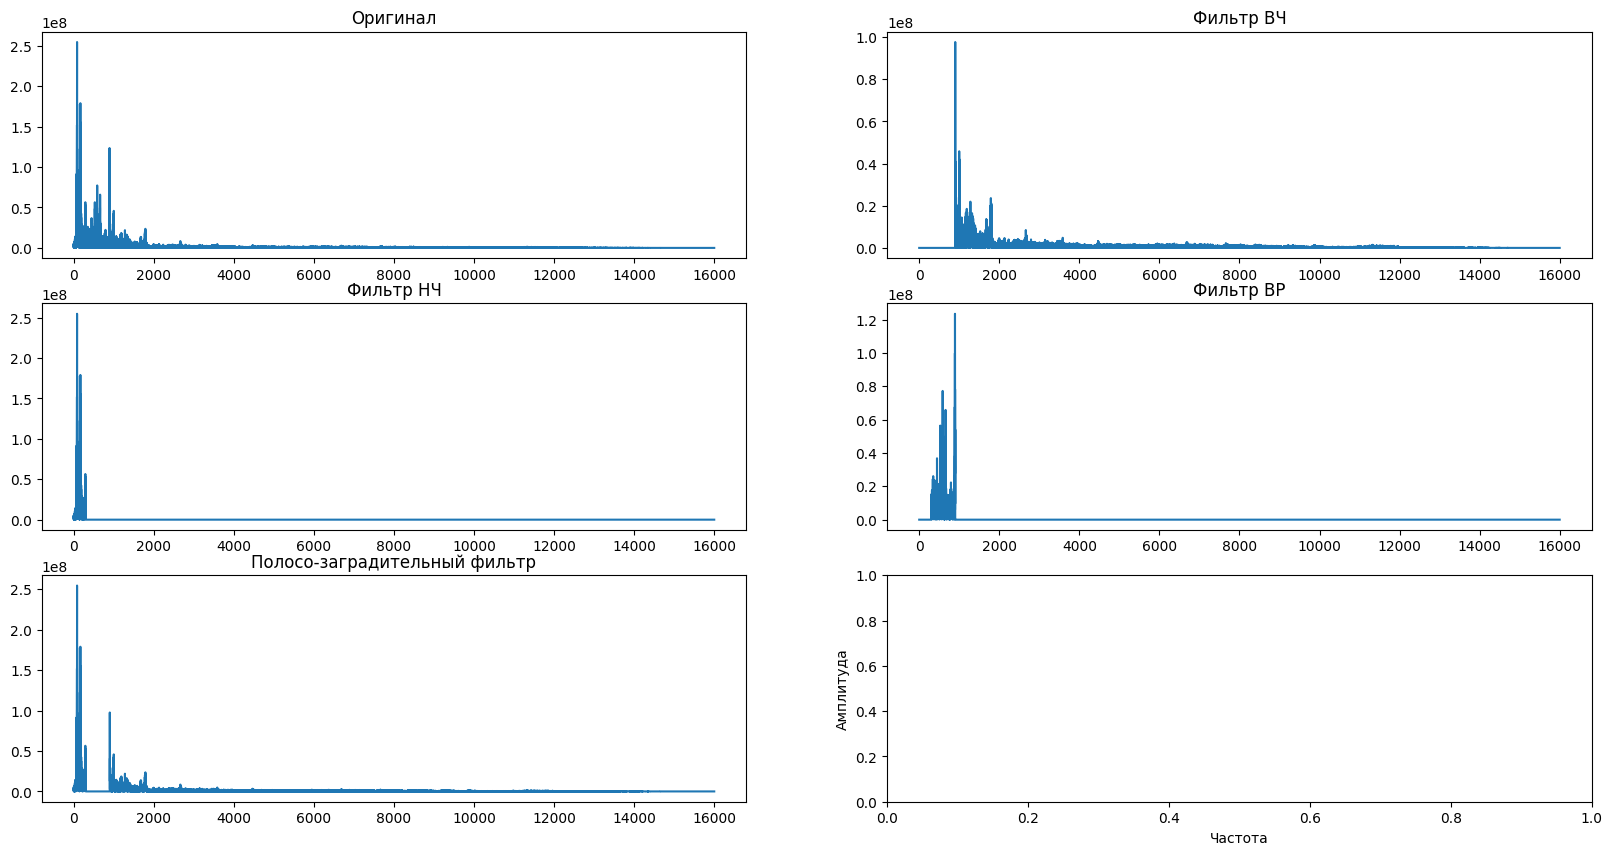

In [10]:
fig, ax = plt.subplots(nrows=3 , ncols=2, figsize=(20, 10))

ax[0,0].plot(xf, np.abs(yf))
ax[0,0].set_title("Оригинал")

ax[0,1].plot(xf, np.abs(yf_hf))
ax[0,1].set_title("Фильтр ВЧ")

ax[1,0].plot(xf, np.abs(yf_lf))
ax[1,0].set_title("Фильтр НЧ")

ax[1,1].plot(xf, np.abs(yf_bp))
ax[1,1].set_title("Фильтр BP")

ax[2,0].plot(xf, np.abs(yf_zf))
ax[2,0].set_title("Полосо-заградительный фильтр")

plt.xlabel('Частота')
plt.ylabel('Амплитуда')

plt.show()

In [11]:
new_sig_hf = irfft(yf_hf)
new_sig_lf = irfft(yf_lf)
new_sig_bp = irfft(yf_bp)
new_sig_zf = irfft(yf_zf)

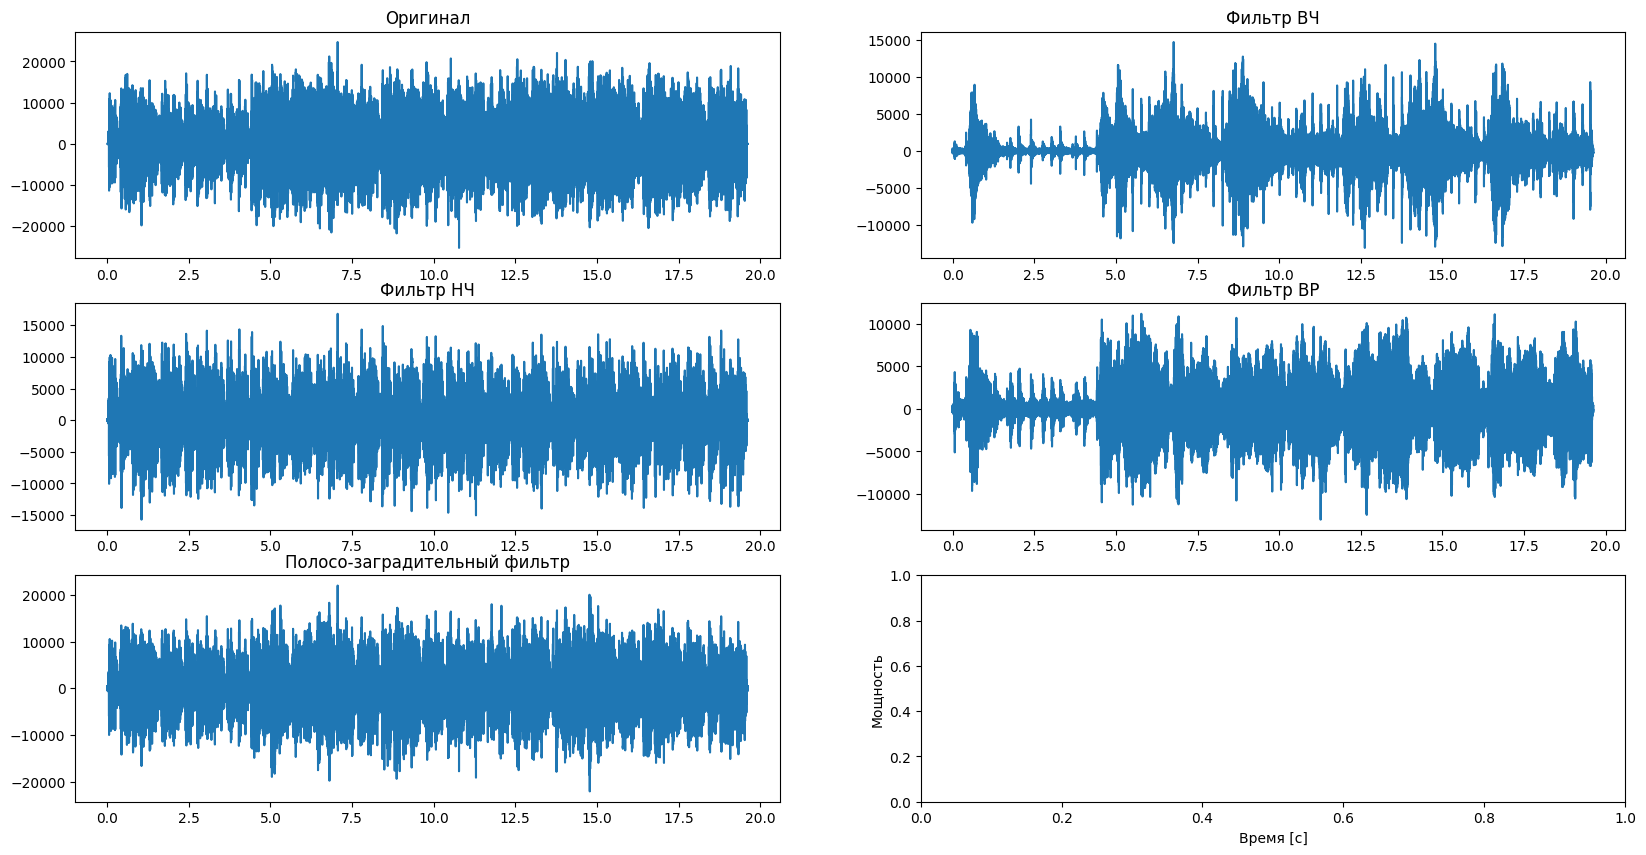

In [12]:
fig, ax = plt.subplots(nrows=3 , ncols=2, figsize=(20, 10))

ax[0,0].plot(time, canal1)
ax[0,0].set_title("Оригинал")

ax[0,1].plot(time, new_sig_hf)
ax[0,1].set_title("Фильтр ВЧ")

ax[1,0].plot(time, new_sig_lf)
ax[1,0].set_title("Фильтр НЧ")

ax[1,1].plot(time, new_sig_bp)
ax[1,1].set_title("Фильтр BP")

ax[2,0].plot(time, new_sig_zf)
ax[2,0].set_title("Полосо-заградительный фильтр")

plt.xlabel('Время [c]')
plt.ylabel('Мощность')

plt.show()

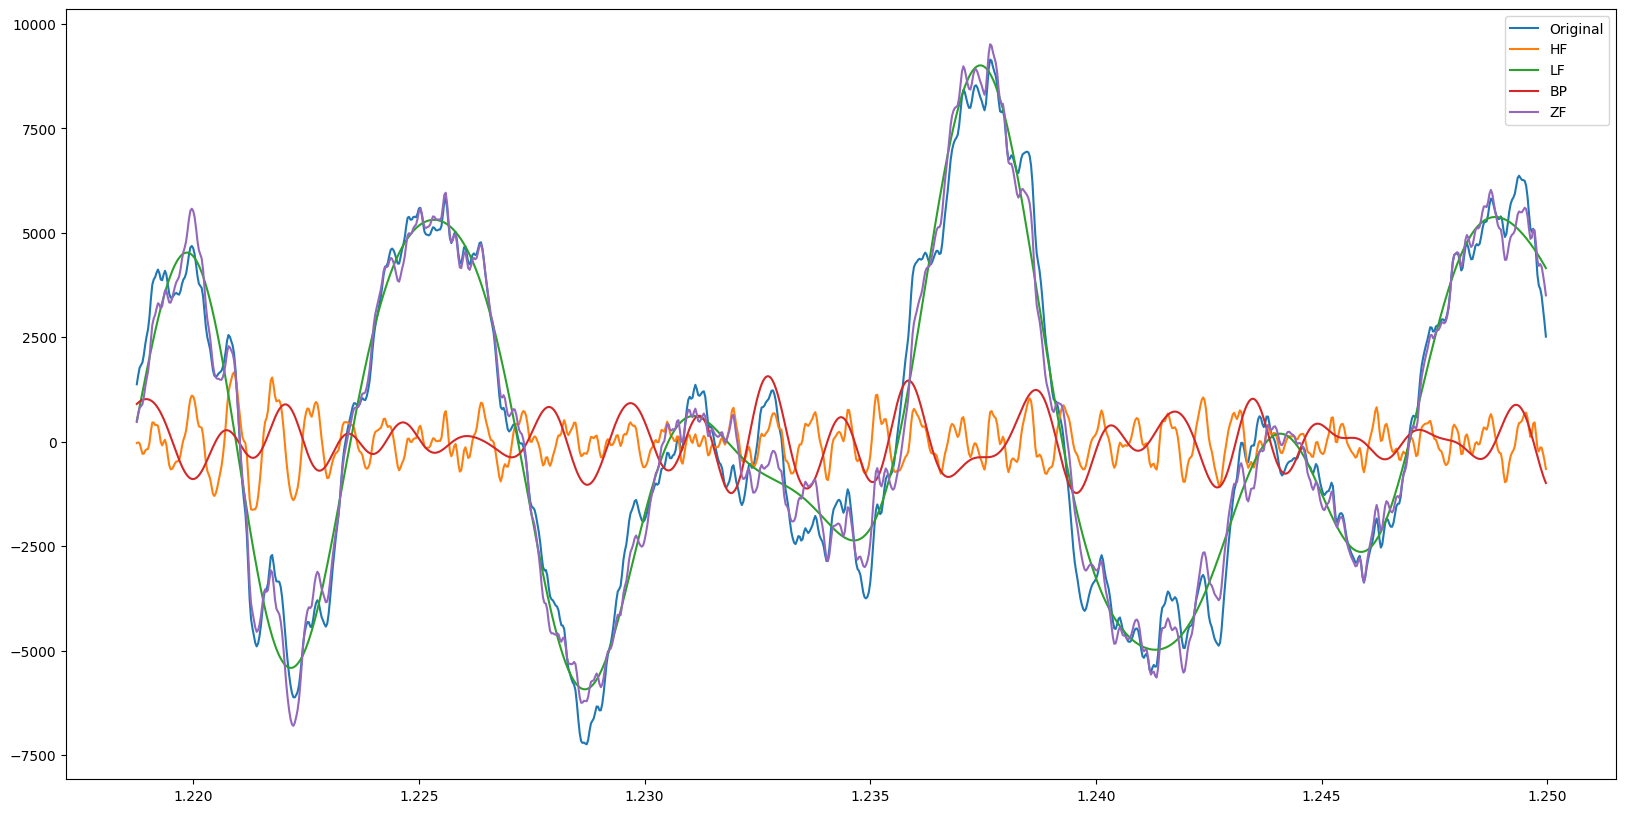

In [13]:
fig, ax = plt.subplots( figsize=(20, 10) )


original, = ax.plot(time[39000:40000], canal1[39000:40000], label='Original')
signal_hf, = ax.plot(time[39000:40000], new_sig_hf[39000:40000], label='HF')
signal_lf, = ax.plot(time[39000:40000], new_sig_lf[39000:40000], label='LF')
signal_bp, = ax.plot(time[39000:40000], new_sig_bp[39000:40000], label='BP')
signal_zf, = ax.plot(time[39000:40000], new_sig_zf[39000:40000], label='ZF')


ax.legend(handles=[original, signal_hf, signal_lf, signal_bp, signal_zf])

plt.show()

In [15]:


def exponential_smoothing(values, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [values[0], values[1]]  # first value is same as series

    for n in range(1, len(values)):
        result.append(alpha * result[n] + (1 - alpha) * values[n-1])

    return result




In [16]:
def plot_exponential_smoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context("seaborn-v0_8-white"):


        plt.figure(figsize=(15, 7))

        plt.plot(series[1], "c", label="Actual")

        for alpha in alphas:
            plt.plot(
                exponential_smoothing(series[1], alpha), label="Alpha {}".format(alpha)
            )


        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)

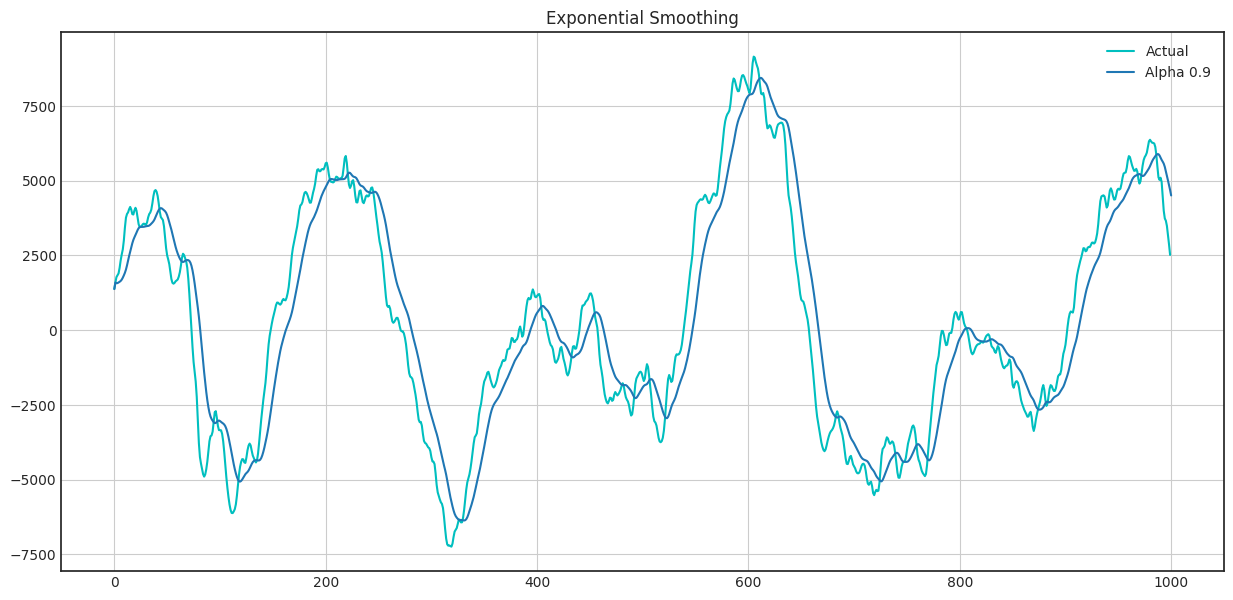

In [20]:
signal_part = canal1[39000:40000]
time_part = time[39000:40000]

series = pd.Series([time[39000:40000],canal1[39000:40000]])

plot_exponential_smoothing(series, alphas=[0.9])

In [21]:
def double_exponential_smoothing(values, alpha, beta):
    result = [values[0]]
    for n in range(1, len(values)+1):
        if n == 1:
            level, trend = values[0], values[1] - values[0]
        if n >= len(values): # прогнозируем
            value = values[-1]
        else:
            value = values[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

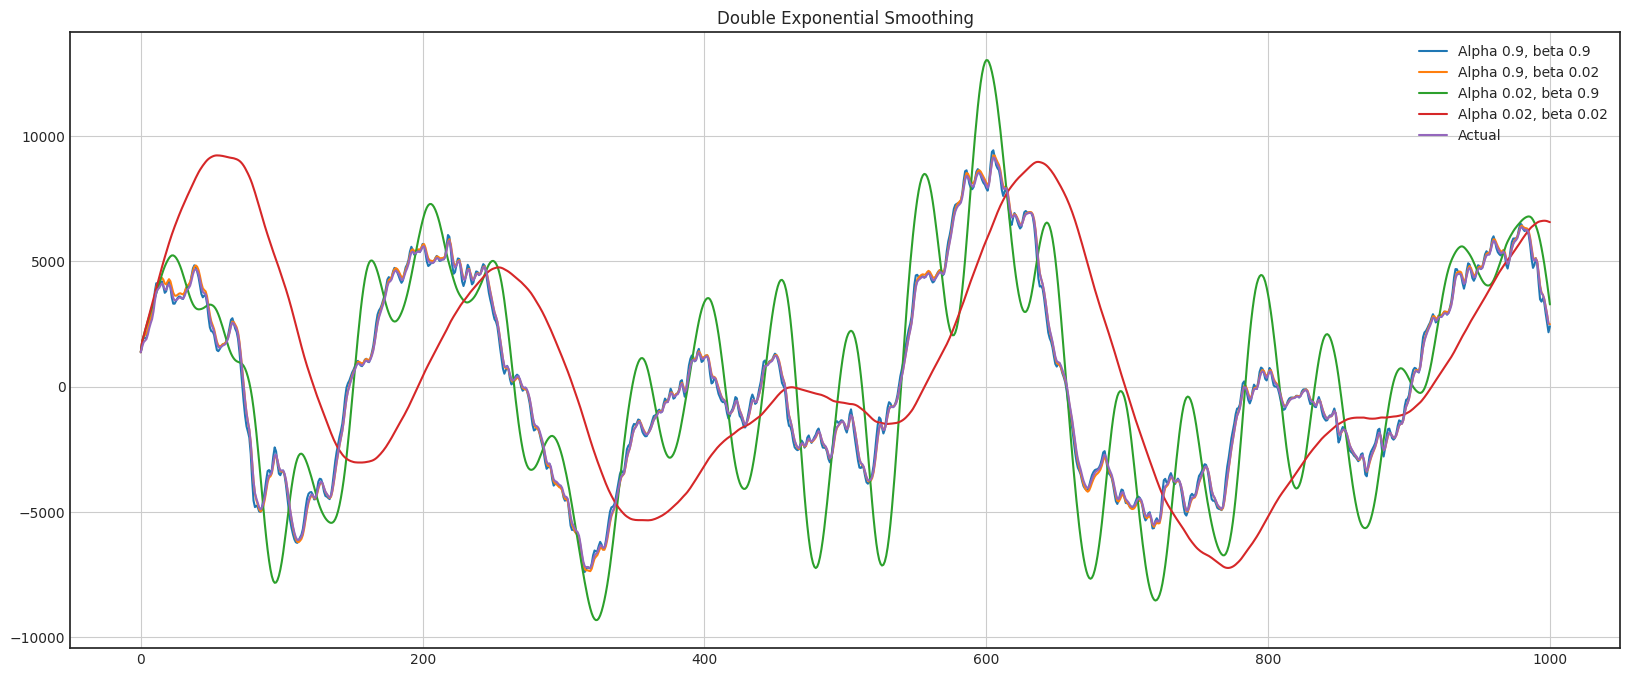

In [22]:

with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(signal_part, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(signal_part, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)


In [23]:


# вспомогательная функция, рассчитываем тренд

def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen



In [24]:
# рассчитываем сезонные компоненты

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

In [25]:
# ну и само сглаживание и предсказание

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

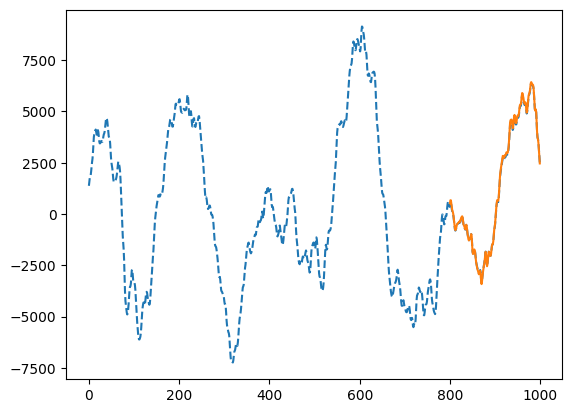

In [26]:


# предсказываем следующие 50 точек
count = 200
ind = len(signal_part) - count
vals = triple_exponential_smoothing(signal_part, 12, 0.716, 0.029, 0.993, count)
# вырезаем отрезок по x, чтобы посмотреть
x = range(ind + count)
x_pr = range(ind, ind + count)
# отрисовываем. Сплошная линия - предсказание.
plt.plot(x[:], signal_part[:], linestyle='dashed')
plt.plot(x_pr, vals[ind:ind+count])



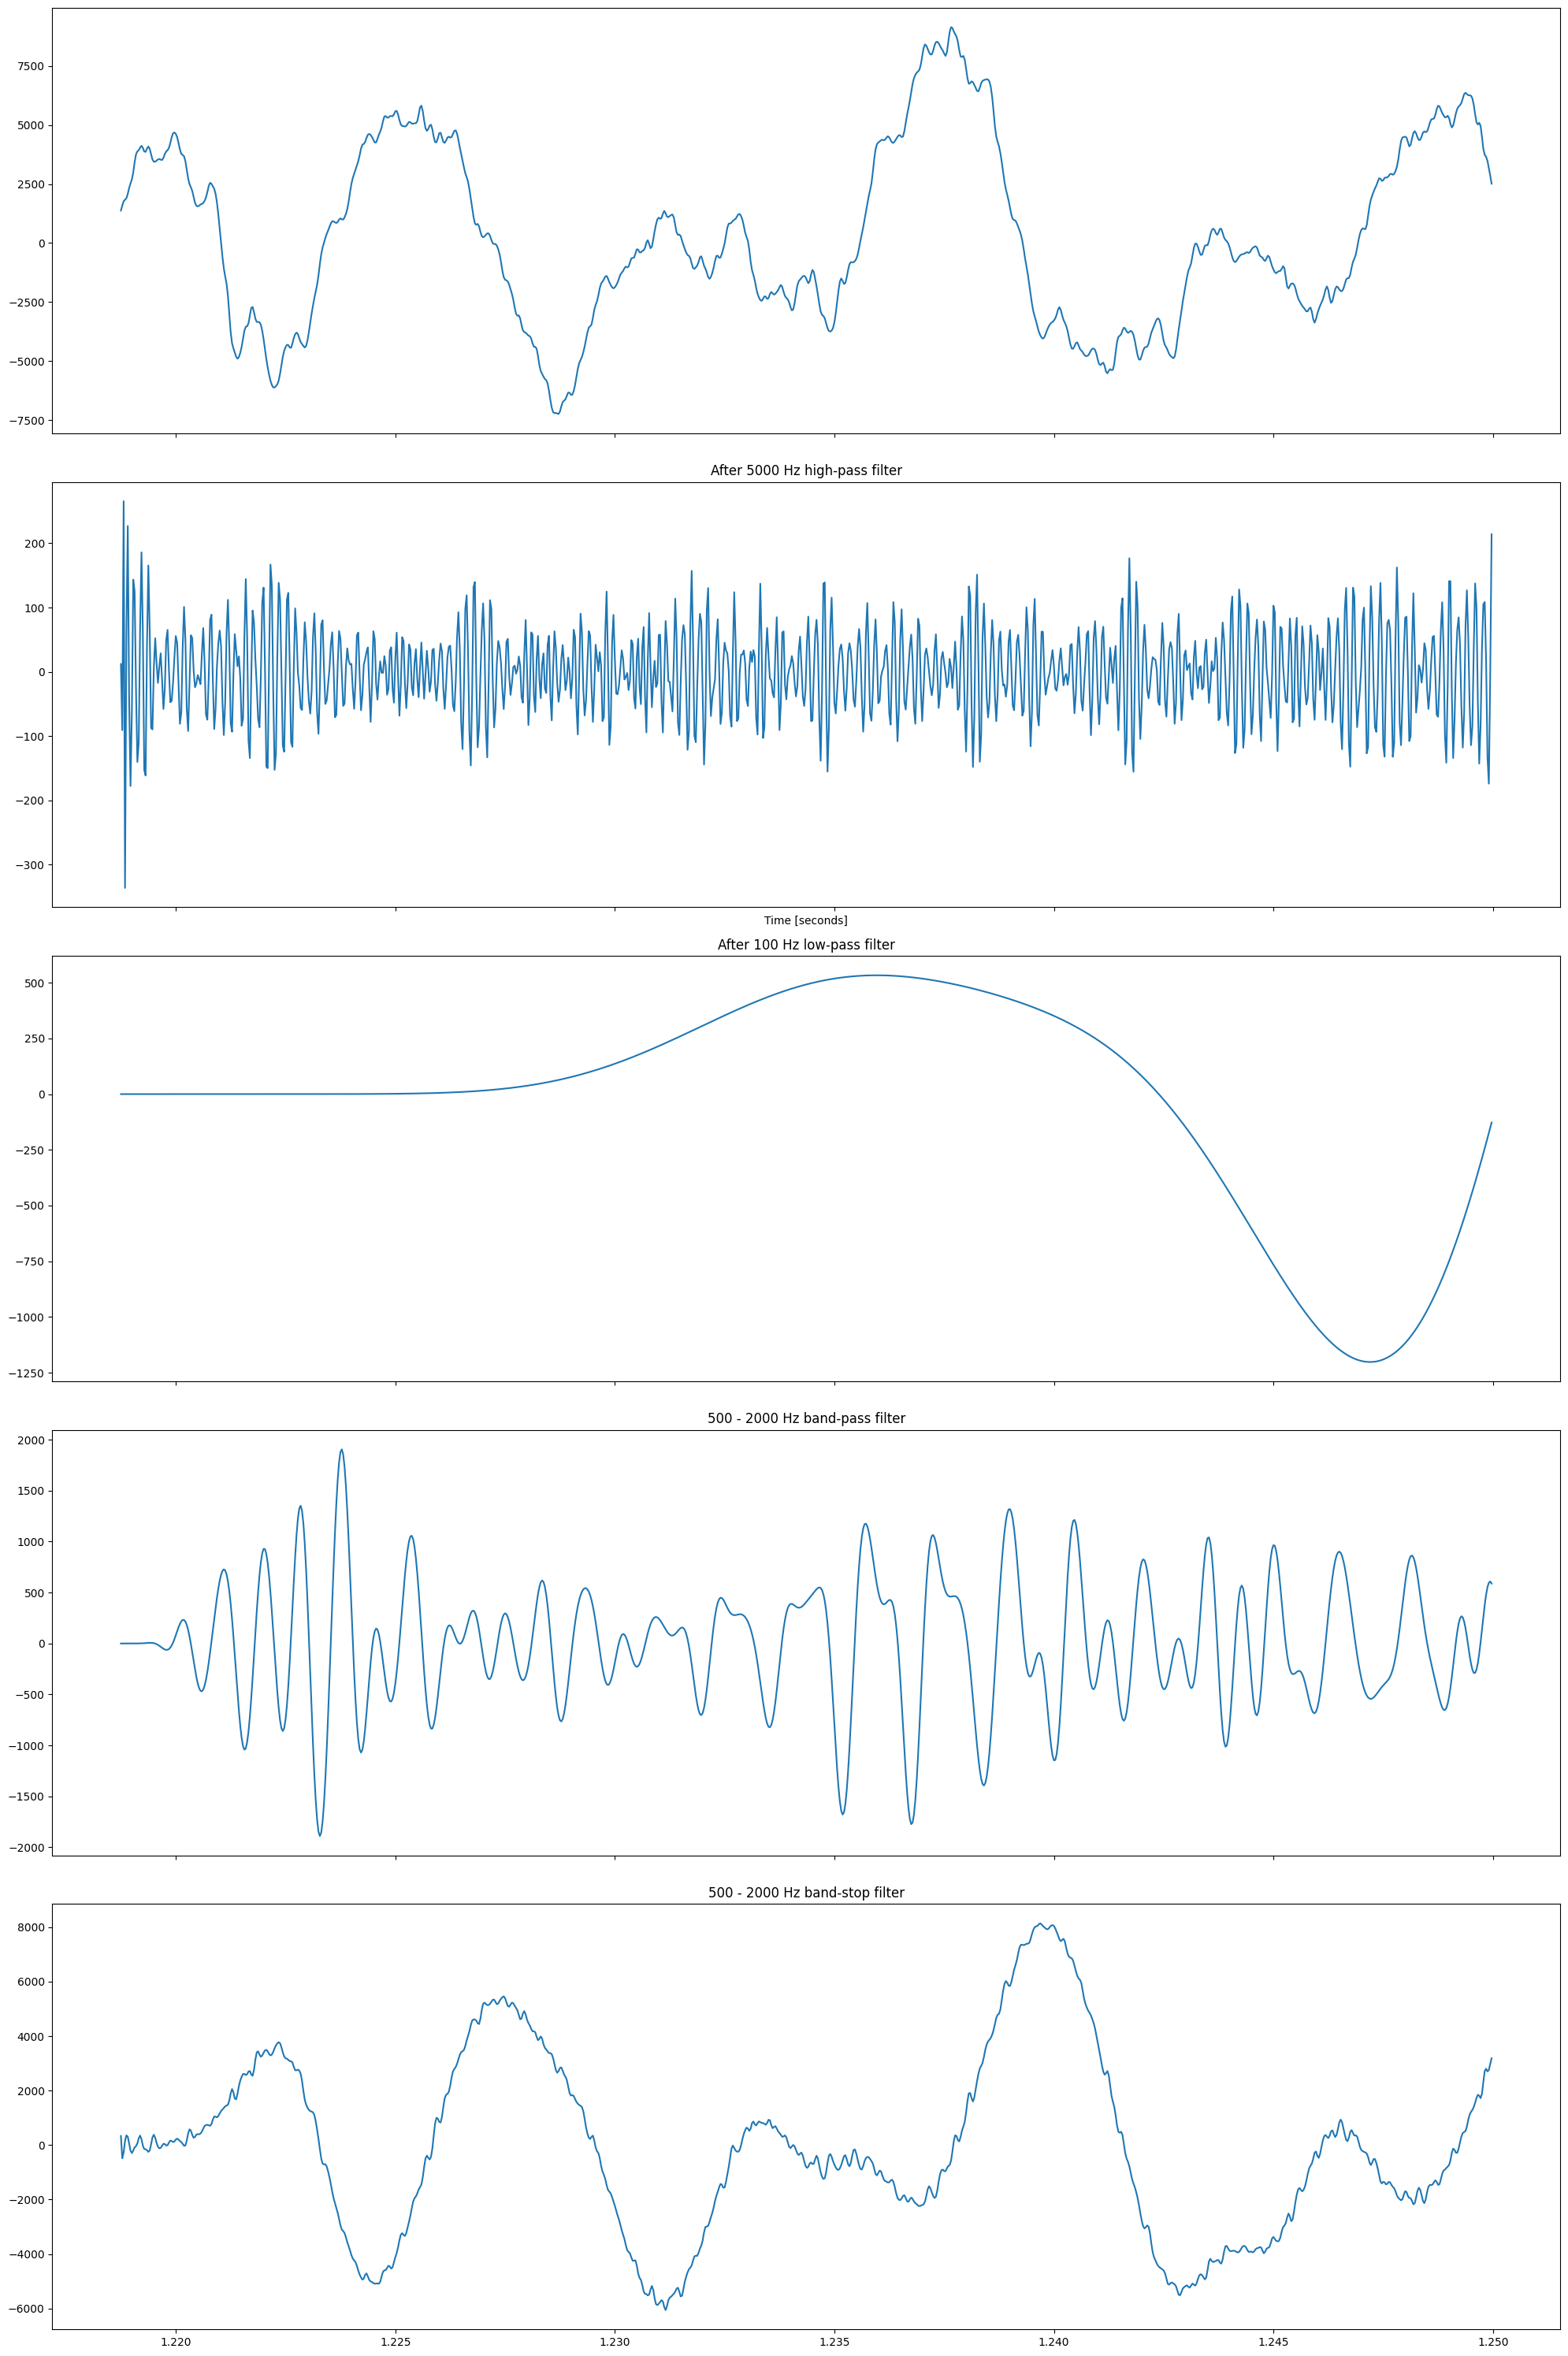

In [27]:
# high pass
sos_hp = signal.cheby1(10, 1, 5000, 'hp', fs=samplerate, output='sos')
filtered_hp = signal.sosfilt(sos_hp, signal_part)


# low pass
sos_lp = signal.cheby1(10, 1, 100, 'lp', fs=samplerate, output='sos')
filtered_lp = signal.sosfilt(sos_lp, signal_part)


# band pass
sos_bp = signal.cheby1(10, 1, [500, 2000], 'bp', fs=samplerate, output='sos')
filtered_bp = signal.sosfilt(sos_bp, signal_part)

# band pass
sos_bs = signal.cheby1(10, 1, [500, 2000], 'bs', fs=samplerate, output='sos')
filtered_bs = signal.sosfilt(sos_bs, signal_part)


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(20,30))
ax1.plot(time_part, signal_part)

ax2.plot(time_part, filtered_hp)
ax2.set_title('After 5000 Hz high-pass filter')

ax3.plot(time_part, filtered_lp)
ax3.set_title('After 100 Hz low-pass filter')

ax4.plot(time_part, filtered_bp)
ax4.set_title('500 - 2000 Hz band-pass filter')

ax5.plot(time_part, filtered_bs)
ax5.set_title('500 - 2000 Hz band-stop filter')

ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

In [28]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

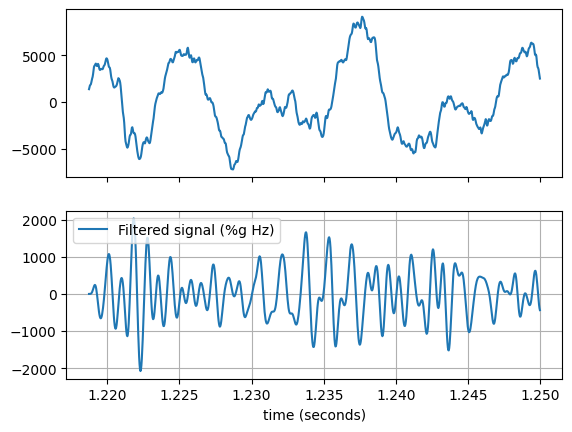

In [29]:
from scipy.signal import butter, lfilter

# Sample rate and desired cutoff frequencies (in Hz).
fs = samplerate

lowcut = 500.0
highcut = 2000.0


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(time_part, signal_part, label='Noisy signal')

y = butter_bandpass_filter(signal_part, lowcut, highcut, fs, order=6)
ax2.plot(time_part, y, label='Filtered signal (%g Hz)')

plt.xlabel('time (seconds)')

plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

In [2]:
!pip install sounddevice

In [3]:
!apt-get install libportaudio2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 65.3 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Fetched 65.3 kB in 0s (245 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 120899 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1_amd64.deb ...
Unpacking libportaudio2:amd64 (19.6.0-1.1) ...
Setting up libportaudio2:amd64 (19.6.0-1.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/lib

In [4]:
!pip install pydub